In [10]:
using Pkg, Plots, Statistics
Pkg.activate("/Users/navaro/JuliaProjects/GEMPIC.jl")
Pkg.update()
using Revise
using GEMPIC

  Activating environment at `~/JuliaProjects/GEMPIC.jl/Project.toml`
    Updating registry at `~/.julia/registries/General`
  No Changes to `~/JuliaProjects/GEMPIC.jl/Project.toml`
  No Changes to `~/JuliaProjects/GEMPIC.jl/Manifest.toml`


In [21]:
σ, μ = 1.0, 0.0
kx, α = 0.5, 0.1
xmin, xmax, nx = 0, 2π / kx, 64
n_particles = 100_000
mesh = OneDGrid(xmin, xmax, nx)
spline_degree = 3

df = CosSumGaussian{1,1}([[kx]], [α], [[σ]], [[μ]])

particle_group = ParticleGroup{1,1}(n_particles)
sampler = ParticleSampler{1,1}(:sobol, n_particles)

sample!(particle_group, sampler, df, mesh)

alpha = df.params.α[1] = 0.1
kx = (df.params.k[1])[1] = 0.5


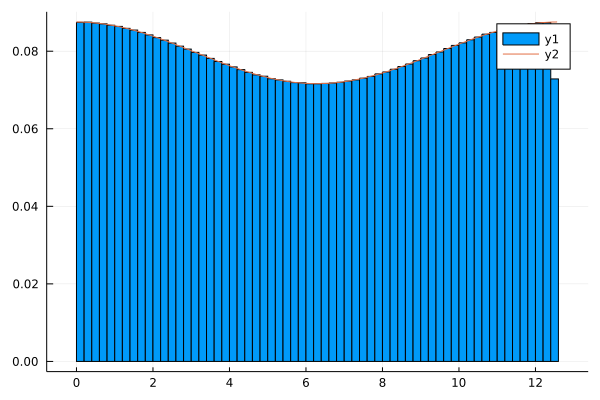

In [22]:
xp = view(particle_group.array, 1, :)
vp = view(particle_group.array, 2, :)
histogram( xp, normalize=true, bins=100 )
plot!( x-> (1+α*cos(kx*x))/(2π/kx), 0., 2π/kx)

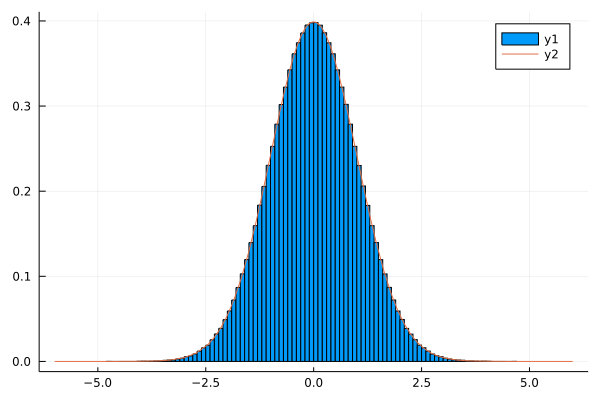

In [23]:
histogram( vp, normalize=true, bins=100 )
plot!( x-> (exp(-x^2/2))/sqrt(2π), -6, 6)

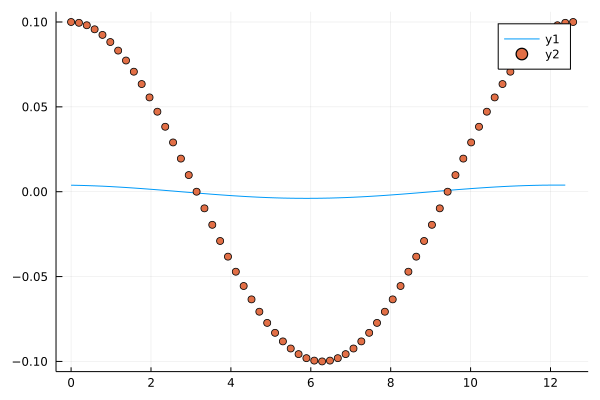

In [28]:
kernel_smoother0 = ParticleMeshCoupling1D(mesh, n_particles, spline_degree, :galerkin)
kernel_smoother1 = ParticleMeshCoupling1D(mesh, n_particles, spline_degree - 1, :galerkin)

rho = zeros(Float64, nx)

for i_part in 1:n_particles
    xi = particle_group.array[1,i_part]
    wi = sqrt(2π) / n_particles #particle_group.array[3,i_part]
    add_charge!(rho, kernel_smoother0, xi, wi)
end

sval = eval_uniform_periodic_spline_curve(spline_degree, rho)
plot(mesh.x[1:end-1], rho .- mean(rho))
scatter!(mesh.x, α * cos.( kx .* mesh.x))

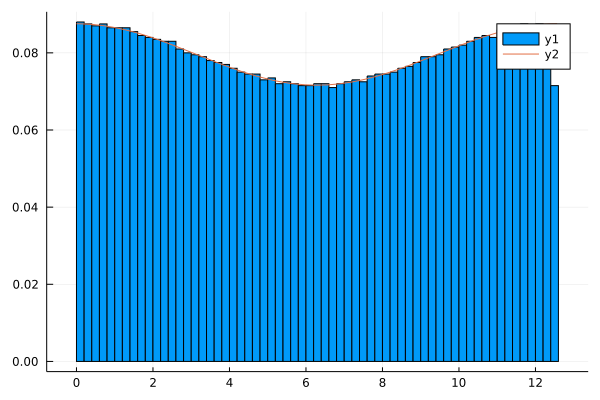

In [37]:
using Sobol
alpha, kx = 0.1, 0.5
xmin, xmax, nx = 0.0, 2π/kx, 10000
dx = (xmax - xmin) / nx
x = LinRange(xmin, xmax, nx+1)[1:end-1]
f = 1 .+ alpha*cos.(kx .* x)
# Construct the CDF numerically and find the closest value 

nbpart = 10000
s  = SobolSeq(1)
xp = Float64[]
for k=0:nbpart-1
   r = next!(s)[1] * 4π
   j = findmin(abs.(v .- r) )[2]
   push!(xp,  x[j])
end

histogram(xp, normalize=true, bins = 100)
plot!(x-> (1+alpha*cos(kx*x))/4π, 0., 4π)

In [40]:
fill!(rho, 0.0)

for i in 1:nbpart
    x_norm = (xp[i]-xmin) / (xmax - xmin)
    ip = trunc(Int,  x_norm * nx)+1
    rho[ip] += 1 / nbpart * 4π
end
plot(rho)

LoadError: BoundsError: attempt to access 64-element Vector{Float64} at index [4999]

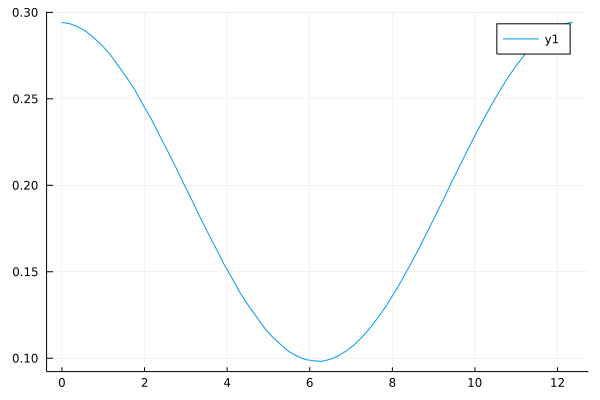

In [6]:
rho = zeros(Float64, nx)
for i in 1:n_particles
    x_norm = (particle_group.array[1,i]-xmin) / (xmax - xmin)
    ip = trunc(Int,  x_norm * nx)+1
    rho[ip] += particle_group.array[3,i]
end
plot(mesh.x[1:end-1], rho)

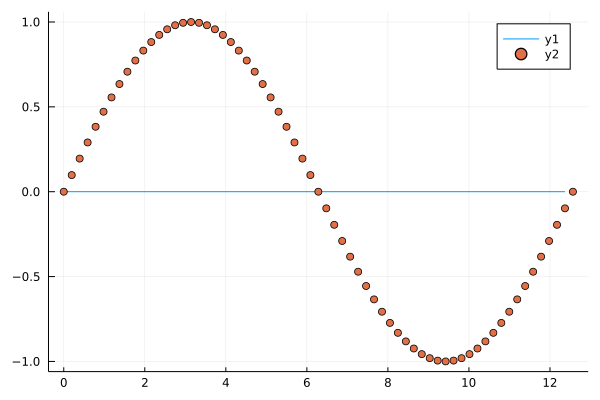

In [46]:
efield_poisson = zeros(Float64, nx)
maxwell_solver = Maxwell1DFEM(mesh, spline_degree)
solve_poisson!(efield_poisson, particle_group, kernel_smoother0, maxwell_solver, rho)

sval = eval_uniform_periodic_spline_curve(spline_degree - 1, efield_poisson)
plot(mesh.x[1:end-1], sval)
scatter!(mesh.x, α / kx * sin.( kx .* mesh.x))

In [ ]:
efield_dofs = [efield_poisson, zeros(Float64, nx), zeros(Float64, nx)]

l2projection!(efield_dofs[2], maxwell_solver, Ey, spline_degree)

    propagator = HamiltonianSplitting(
        maxwell_solver,
        kernel_smoother0,
        kernel_smoother1,
        particle_group,
        efield_dofs,
    )

    efield_dofs_n = propagator.e_dofs

    thdiag = TimeHistoryDiagnostics(
        particle_group, maxwell_solver, kernel_smoother0, kernel_smoother1
    )

    steps, Δt = 2, 0.1

    # Strang splitting
    strang_splitting!(propagator, Δt, 1)

    solve_poisson!(efield_poisson, particle_group, kernel_smoother0, maxwell_solver, rho)

    strang_splitting!(propagator, Δt, 1)

    solve_poisson!(efield_poisson, particle_group, kernel_smoother0, maxwell_solver, rho)

    write_step!(
        thdiag,
        Δt,
        spline_degree,
        efield_dofs,
        efield_dofs_n,
        efield_poisson,
        propagator,
    )